In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import numpy as np
from scipy.spatial import distance
import math
import statistics

In [2]:
#filter specific file names
luminance = 'star_Light_Luminance_3.500_secs_001_reduced_matched.csv'
#luminance = 'RZ_Cep_Light_Luminance_10_secs_001_reduced_matched.csv'
red = 'star_Light_Red_30_secs_001_reduced_matched.csv'
green = 'star_Light_Green_30_secs_001_reduced_matched.csv'
blue = 'star_Light_Blue_30_secs_001_reduced_matched.csv'

#set current filter
ref_csv_name = luminance
current_filter = 'Luminance'

#define file read path and the file list, excluding the first file
#read_path = Path(f'./RZ Cep/All_RZ_Cep/2023_02_23/RZ_Cep/CSVs/Matched Stars/{current_filter}')
read_path = Path(f'./RZ Cep/All_RZ_Cep/2023_11_10/RZ_Cep/CSVs/Matched Stars/{current_filter}')
file_list = [f for f in os.listdir(read_path)if f.endswith('.csv') and f != ref_csv_name]

final_csv_path = Path('./RZ Cep/All_RZ_Cep/Light Curve CSVs/')
final_csv_name = '2023_11_10_normalised_curve.csv'

In [3]:
#column names
mag_name = 'instrumental_mag'
mag_error_name = 'mag_error'
corr_mag_name = 'corrected_mag'
date_time_name = 'date_time'
exp_time_name = 'exp_time'
star_id_name = 'star_id'
x_pos_name = 'x_center'
y_pos_name = 'y_center'

In [4]:
'''
#set up a dictionary of valid star names 
valid_stars = None

#set up a list which will contain dictionaries of stars and their associated magnitudes, date/times and exposure times
star_properties = []
to_delete = []

#enumerate adds an index to each file in the list
for i, fname in enumerate(file_list):
    #read in the dataframe
    df = pd.read_csv(read_path / fname)
    #add an empty dictionary to star_properties
    star_properties.append({})
    
    #if the dictionary valid_stars has not been created, create it
    #assumes all stars in the first dataframe (image 2) appear only once, which they do
    if valid_stars is None:
        valid_stars = {}
        #iterate through row and associated index in the dataframe, iterrows allows for this
        for idx, row in df.iterrows():
            #extract star name from dataframe
            star_name = row['star_id']
            #checks for valid magnitudes (i.e. not from negative fluxes)
            if row['instrumental_mag'] != np.nan:
                #set up new row in the star_properties dictionary (index i to be associated with dataframe/image i) to save
                #the star name and its associated image number, magnitude, date/time and exposure time
                star_properties[i][star_name] = {
                    'img_number': i + 1,
                    'instrumental_mag': float(row['instrumental_mag']),
                    'corr_mag': float(row['corrected_mag']),
                    'mag_error': float(row['mag_error']),
                    'date_time': str(row['date_time']),
                    'exp_time': float(row['exp_time'])
                }
                #add new row to valid_stars dictionary to save the position values
                valid_stars[star_name] = (row['x_center'], row['y_center'])
                
    #if valid_stars has already been created, so for any other dataframe that is not the first one:            
    else:
        #counts how many times each star's name has occured in the dataframe
        vcounts = df['star_id'].value_counts()
        #iterates through star names and positions saved in the valid_stars dictionary
        for star_name, (xpos, ypos) in valid_stars.items():
            #run if the star is in the dataframe, otherwise the star will not be considered this loop iteration
            if star_name in vcounts:
                #if the star appears only once in the dataframe, run this
                if vcounts[star_name] == 1:   
                    #all properties must be type converted first here, as they output as a pd.string when using df.loc
                    mag = float(df.loc[df['star_id'] == star_name]['instrumental_mag'])
                    err = float(df.loc[df['star_id'] == star_name]['mag_error'])
                    #print((df.loc[df['star_id'] == star_name]['corrected_mag']))
                    corr = float(str(df.loc[df['star_id'] == star_name]['corrected_mag'].iloc[0])),
                    #time needs to be output as a string, using just str() didn't eliminate the associated index
                    #first, it is converted to a list and the zeroth index value (the only value) converted into a string, 
                    #which gets around this issue
                    time = str(list(df.loc[df['star_id'] == star_name]['date_time'])[0])
                    img_exptime = float(df.loc[df['star_id'] == star_name]['exp_time'])
                    if mag != np.nan and not math.isnan(mag):
                        #properties are saved to the dictionary, added to the section corresponding to that star
                        star_properties[i][star_name] = {
                                'img_number': i + 1,
                                'instrumental_mag': mag,
                                'corr_mag': corr,
                                'mag_error': err,
                                'date_time': time,
                                'exp_time': img_exptime
                            }
                    else:
                        to_delete.append(star_name)
                #if the star appears more or less than once, run this
                else:
                    #save the previous position to a variable
                    prev_pos = (xpos, ypos)
                    #set up an arbitrary minimum distance
                    min_dist = np.inf
                    #iterate through all the duplicate instances of the star in the dataframe
                    for idx, row in df[df['star_id'] == star_name].iterrows():
                        #test if the distance between the position of this star instance is less than either the arbitrary
                        #distance or the other points associated with other instances of the star in the dataframe.
                        #if the new distance is less than the min distance for other star instances, the current instance
                        #is more likely to be the correct star and not a mislabeled one
                        if row["instrumental_mag"] != np.nan and not math.isnan(row["instrumental_mag"]):
                            if distance.euclidean(prev_pos, (row['x_center'], row['y_center'])) < min_dist:
                                #update the new minimum point distance
                                min_dist = distance.euclidean(prev_pos, (row['x_center'], row['y_center']))
                                #save star properties to dictionary
                                star_properties[i][star_name] = {
                                        'img_number': i + 1,
                                        'instrumental_mag': float(row['instrumental_mag']),
                                        'corr_mag': float(str(row['corrected_mag'])),
                                        'mag_error': float(row['mag_error']),
                                        'date_time': str(row['date_time']),
                                        'exp_time': float(row['exp_time'])
                                    }
                                #overwrite star position in valid_stars                          
                                valid_stars[star_name] = (row['x_center'], row['y_center'])
                        #if the star is not in the image, add it a list of star names to be removed (first condition)
                        else:
                            to_delete.append(star_name)
            #if the star is not in the image, add it to a list of stars to be deleted (second condition)
            else:
                to_delete.append(star_name)
        
        #iterate over star names saved in list of stars to be deleted
        for star_name in to_delete:
        #delete saved position values for misidentification purposes
            del valid_stars[star_name]
            #delete all previous iterations of the star saved in the loop
            for idx, previous_iters in enumerate(star_properties):
                if star_name in previous_iters:
                    del star_properties[idx][star_name]
        
        #reset the list of stars to delete, so stars are not removed twice
        to_delete = []
                        
                        
                
#print(valid_stars)
# print(star_properties)

#print dictionary properties for RZ Cep
# for star_num in star_properties:
#     print(star_num['V* RZ Cep'])
    
#print all star names saved in star_properties dictionary
for star_name in star_properties[0]:
    print(star_name)
'''

'\n#set up a dictionary of valid star names \nvalid_stars = None\n\n#set up a list which will contain dictionaries of stars and their associated magnitudes, date/times and exposure times\nstar_properties = []\nto_delete = []\n\n#enumerate adds an index to each file in the list\nfor i, fname in enumerate(file_list):\n    #read in the dataframe\n    df = pd.read_csv(read_path / fname)\n    #add an empty dictionary to star_properties\n    star_properties.append({})\n    \n    #if the dictionary valid_stars has not been created, create it\n    #assumes all stars in the first dataframe (image 2) appear only once, which they do\n    if valid_stars is None:\n        valid_stars = {}\n        #iterate through row and associated index in the dataframe, iterrows allows for this\n        for idx, row in df.iterrows():\n            #extract star name from dataframe\n            star_name = row[\'star_id\']\n            #checks for valid magnitudes (i.e. not from negative fluxes)\n            if ro

In [5]:
#set up a dictionary of valid star names 
valid_stars = None

#set up a list which will contain dictionaries of stars and their associated magnitudes, date/times and exposure times
star_properties = []
to_delete = []
star_counter = {}


#enumerate adds an index to each file in the list
for i, fname in enumerate(file_list):
    #read in the dataframe
    df = pd.read_csv(read_path / fname)
    #add an empty dictionary to star_properties
    star_properties.append({})
    
    #if the dictionary valid_stars has not been created, create it
    #assumes all stars in the first dataframe (image 2) appear only once, which they do
    if valid_stars is None:
        valid_stars = {}
        #iterate through row and associated index in the dataframe, iterrows allows for this
        for idx, row in df.iterrows():
            #extract star name from dataframe
            star_name = row[star_id_name]
            #checks for valid magnitudes (i.e. not from negative fluxes)
            if row[mag_name] != np.nan:
                #set up new row in the star_properties dictionary (index i to be associated with dataframe/image i) to save
                #the star name and its associated image number, magnitude, date/time and exposure time
                star_properties[i][star_name] = {
                    'img_number': i + 1,
                    'instrumental_mag': float(row[mag_name]),
                    'corr_mag': float(row[corr_mag_name]),
                    'mag_error': float(row[mag_error_name]),
                    'date_time': str(row[date_time_name]),
                    'exp_time': float(row[exp_time_name])
                }
                #add new row to valid_stars dictionary to save the position values
                valid_stars[star_name] = (row[x_pos_name], row[y_pos_name])
                
    #if valid_stars has already been created, so for any other dataframe that is not the first one:            
    else:
        #counts how many times each star's name has occured in the dataframe
        vcounts = df[star_id_name].value_counts()
        #iterates through star names and positions saved in the valid_stars dictionary
        for star_name, (xpos, ypos) in valid_stars.items():
            #run if the star is in the dataframe, otherwise the star will not be considered this loop iteration
            if star_name in vcounts:
                # Count times star shows up to prune later
                if star_name in star_counter:
                    star_counter[star_name] += 1
                else:
                    star_counter[star_name] = 1
                #if the star appears only once in the dataframe, run this
                if vcounts[star_name] == 1:   
                    #all properties must be type converted first here, as they output as a pd.string when using df.loc
                    mag = float(df.loc[df[star_id_name] == star_name][mag_name])
                    err = float(df.loc[df[star_id_name] == star_name][mag_error_name])
                    #print((df.loc[df['star_id'] == star_name]['corrected_mag']))
                    corr = float(str(df.loc[df[star_id_name] == star_name][corr_mag_name].iloc[0])),
                    #time needs to be output as a string, using just str() didn't eliminate the associated index
                    #first, it is converted to a list and the zeroth index value (the only value) converted into a string, 
                    #which gets around this issue
                    time = str(list(df.loc[df[star_id_name] == star_name][date_time_name])[0])
                    img_exptime = float(df.loc[df[star_id_name] == star_name][exp_time_name])
                    if mag != np.nan and not math.isnan(mag):
                        #properties are saved to the dictionary, added to the section corresponding to that star
                        star_properties[i][star_name] = {
                                'img_number': i + 1,
                                'instrumental_mag': mag,
                                'corr_mag': corr,
                                'mag_error': err,
                                'date_time': time,
                                'exp_time': img_exptime
                            }
                    else:
                        star_counter[star_name] -= 1
                #if the star appears more or less than once, run this
                else:
                    #save the previous position to a variable
                    prev_pos = (xpos, ypos)
                    #set up an arbitrary minimum distance
                    min_dist = np.inf
                    #iterate through all the duplicate instances of the star in the dataframe
                    for idx, row in df[df[star_id_name] == star_name].iterrows():
                        #test if the distance between the position of this star instance is less than either the arbitrary
                        #distance or the other points associated with other instances of the star in the dataframe.
                        #if the new distance is less than the min distance for other star instances, the current instance
                        #is more likely to be the correct star and not a mislabeled one
                        if row[mag_name] != np.nan and not math.isnan(row[mag_name]):
                            if distance.euclidean(prev_pos, (row[x_pos_name], row[y_pos_name])) < min_dist:
                                #update the new minimum point distance
                                min_dist = distance.euclidean(prev_pos, (row[x_pos_name], row[y_pos_name]))
                                #save star properties to dictionary
                                star_properties[i][star_name] = {
                                        'img_number': i + 1,
                                        'instrumental_mag': float(row[mag_name]),
                                        'corr_mag': float(row[corr_mag_name]),
                                        'mag_error': float(row[mag_error_name]),
                                        'date_time': str(row[date_time_name]),
                                        'exp_time': float(row[exp_time_name])
                                    }
                                #overwrite star position in valid_stars                          
                                valid_stars[star_name] = (row[x_pos_name], row[y_pos_name])
                        #if the star is not in the image, add it a list of star names to be removed (first condition)
        
#         #iterate over star names saved in list of stars to be deleted
#         for star_name in to_delete:
#         #delete saved position values for misidentification purposes
#             del valid_stars[star_name]
#             #delete all previous iterations of the star saved in the loop
#             for idx, previous_iters in enumerate(star_properties):
#                 if star_name in previous_iters:
#                     del star_properties[idx][star_name]
        
        #reset the list of stars to delete, so stars are not removed twice
#         to_delete = []
                        
max_star_count = max(star_counter.values())
print(star_counter)
for starname, count in star_counter.items():
    if count < (0.97 * max_star_count):
        for idx, previous_iters in enumerate(star_properties):
            if starname in previous_iters:
                del star_properties[idx][starname]
        
        
                
#print(valid_stars)
# print(star_properties)

#print dictionary properties for RZ Cep
# for star_num in star_properties:
#     print(star_num['V* RZ Cep'])
    
#print all star names saved in star_properties dictionary
for star_name in star_properties[0]:
    print(star_name)

{'V* RZ Cep': 45, 'TYC 4273-435-1': 44, 'TYC 4273-1351-1': 45, 'BD+64  1700': 44, 'TYC 4273-876-1': 45, '2MASS J22405245+6505370': 45, 'LSPM J2241+6501': 45, 'IRAS 22404+6450': 45, 'TYC 4273-668-1': 45, '2MASS J22420892+6508103': 45, 'TYC 4273-884-1': 45, 'IRAS 22364+6432': 45, 'UCAC4 774-052682': 45, 'TYC 4273-922-1': 45, '2MASS J22365043+6456254': 45, 'GSH 109+06-32': 44, 'TYC 4273-307-1': 44, 'TYC 4273-149-1': 45, 'TYC 4273-659-1': 44, 'TYC 4273-858-1': 45, 'TYC 4273-673-1': 45, 'NVSS J224004+645852': 44, 'Gaia DR2 2211583698432680064': 45, 'TYC 4273-343-1': 44, 'UCAC4 776-050735': 43, 'Gaia DR3 2212402667093547008': 45, 'Gaia DR3 2212396207462733568': 45, 'UCAC4 776-050768': 43, 'TYC 4273-822-1': 44, 'UCAC4 776-050859': 45, 'TYC 4273-1186-1': 44, 'TYC 4273-293-1': 43, 'NVSS J224054+645420': 45, 'Ross  214': 41, 'TYC 4273-609-1': 42, '1RXS J223959.9+643330': 42, 'Gaia DR3 2211625479874273536': 45, 'TYC 4273-1038-1': 42, 'Gaia DR3 2211625484173740928': 41, 'UCAC4 774-052557': 44, 'Ga

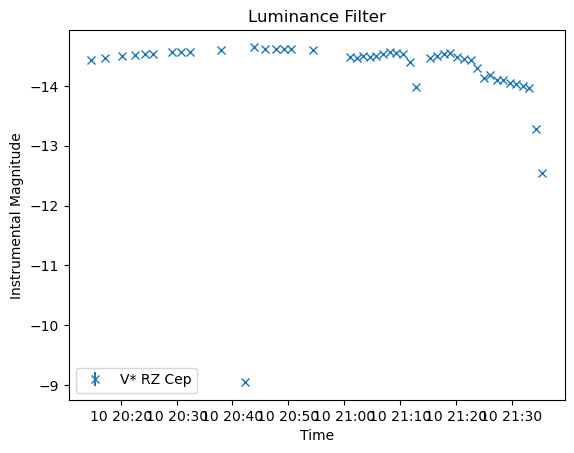

In [6]:
#plot example stars
img_num_star = []
inst_mag_star = []
mag_err = []
date_time_star = []
exp_time_star = []
corrected_mag = []
corrected_err = []

star_name = 'V* RZ Cep'

#funky lookin stars when plotting all:
#Gaia DR2 2211583698432680064 - drops off a lot
#TYC 4273-858-1 - very noisy, looks like it jumps between stars
#UCAC4 774-052682 - curves downward in some places
#IRAS 22364+6432 - also curves down, missing lots of data
#TYC 4273-900-1 - curves downward in two places
#UCAC4 776-050859 - six data points


for obs_data in star_properties:
    if star_name in obs_data:
        img_num_star.append(obs_data[star_name]['img_number'])
        inst_mag_star.append(obs_data[star_name]['instrumental_mag'])
        mag_err.append(abs(obs_data[star_name]['mag_error']))
        date_time_star.append(obs_data[star_name]['date_time'])
        exp_time_star.append(obs_data[star_name]['exp_time'])
        
        if len(corrected_mag) == 0:
            corrected_mag.append(obs_data[star_name]['corr_mag'])
        else:
            corrected_mag.append(obs_data[star_name]['corr_mag'][0])
        
date_time_star = pd.to_datetime(date_time_star)
#print(mag_err)

plt.errorbar(date_time_star, corrected_mag, yerr=mag_err, marker='x', ls='None', label=star_name)
plt.title('Luminance Filter')
plt.xlabel('Time')
plt.ylabel('Instrumental Magnitude')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [7]:
'''
#define a correction factor function to apply to each star individually
def get_correction_factors(magnitudes: list[float]) -> list[float]:
    #set reference point as first image data set
    ref_mag = magnitudes[0]
    #set the first correction factor associated with the first image data set to 1
    corr_factors = [1]
    #iterate over all image data sets, excluding the first one
    for mag_current_image in magnitudes[1:]:
        #append the corrected factors array with a correction factor for each image
        corr_factors.append(ref_mag / mag_current_image)
    #return the correction factors for this star
    return corr_factors


#save list of star names without star of interest
names_without_cep = star_properties[0].keys() - {'V* RZ Cep'}
#set up a new empty dictionary conatining all the star names without rz cep
star_datapoints = {key: [] for key in names_without_cep}

#for each image in the star_properties list of dicts of dicts
for image in star_properties:
    #iterate over the star names without rz cep
    for star_name in names_without_cep:
        if star_name in image:
            if isinstance(image[star_name]['corr_mag'], tuple):
                star_datapoints[star_name].append(image[star_name]['corr_mag'][0])
            else:
                star_datapoints[star_name].append(image[star_name]['corr_mag'])
        else:
            star_datapoints[star_name].append(star_datapoints[star_name]['corr_mag'][0])


#create a list of lists containing all image by image correction factors for each individual star
imgbyimg_factors = [get_correction_factors(val) for key, val in star_datapoints.items()]

# print(imgbyimg_factors[0])
#set up list of lists containing the mean and std of each image's correction factors
condensed_correction_factors = [
    [
        np.mean([row[colnum] for row in imgbyimg_factors]),
        np.std([row[colnum] for row in imgbyimg_factors])
    ] for colnum, _ in enumerate(imgbyimg_factors[0])
]
# condensed_correction_factors = []
# for row in imgbying_factors:
    
    
# print(condensed_correction_factors)
#print(len(condensed_correction_factors))
#first sq bracket changes image, second square bracket changes between mean and standard deviation
#print(condensed_correction_factors[0][1])
'''

"\n#define a correction factor function to apply to each star individually\ndef get_correction_factors(magnitudes: list[float]) -> list[float]:\n    #set reference point as first image data set\n    ref_mag = magnitudes[0]\n    #set the first correction factor associated with the first image data set to 1\n    corr_factors = [1]\n    #iterate over all image data sets, excluding the first one\n    for mag_current_image in magnitudes[1:]:\n        #append the corrected factors array with a correction factor for each image\n        corr_factors.append(ref_mag / mag_current_image)\n    #return the correction factors for this star\n    return corr_factors\n\n\n#save list of star names without star of interest\nnames_without_cep = star_properties[0].keys() - {'V* RZ Cep'}\n#set up a new empty dictionary conatining all the star names without rz cep\nstar_datapoints = {key: [] for key in names_without_cep}\n\n#for each image in the star_properties list of dicts of dicts\nfor image in star_prop

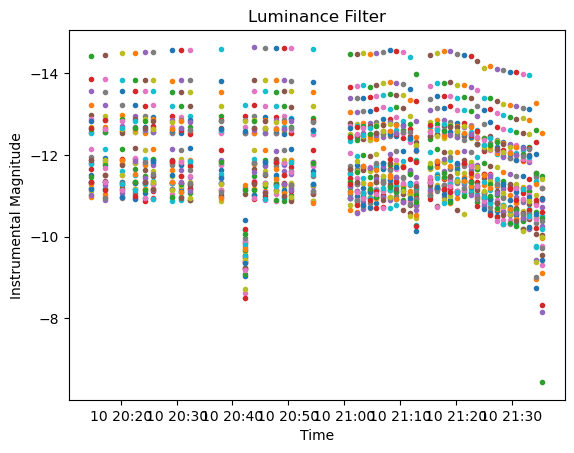

In [8]:
#plot all stars
for obs_data in range(len(star_properties)):
    for star_name in star_properties[obs_data]:
        img_num = []
        inst_mag = []
        date_time = []
        exp_time = []
        mag_err = []
        corrected_mag = []
        
        img_num.append(star_properties[obs_data][star_name]['img_number'])
        inst_mag.append(star_properties[obs_data][star_name]['instrumental_mag'])
        mag_err.append(abs(star_properties[obs_data][star_name]['mag_error']))
        date_time.append(star_properties[obs_data][star_name]['date_time'])
        exp_time.append(star_properties[obs_data][star_name]['exp_time'])
        
        if len(corrected_mag) == 0:
            corrected_mag.append(star_properties[obs_data][star_name]['corr_mag'])
        else:
            corrected_mag.append(star_properties[obs_data][star_name]['corr_mag'][0])
        
        date_time = pd.to_datetime(date_time)
        plt.errorbar(date_time, corrected_mag, yerr=mag_err, marker='.', ls='None', label=star_name)
        del img_num, inst_mag, mag_err, date_time, exp_time, corrected_mag
    
plt.title('Luminance Filter')
plt.xlabel('Time')
plt.ylabel('Instrumental Magnitude')
plt.gca().invert_yaxis()
# plt.legend()
plt.show()

In [9]:
def get_correction_factor_img_by_img(dict_list: list[dict[dict]], corrected_magnitude_name):
    reference_for_stars: dict = {}
    final_correction_factors: list[list[float, float]] = []
    temp_correction_factors: list = []
    for image in dict_list:
        if image is dict_list[0]:
#            list of all magnitudes in image 1, to compare to

            reference_for_stars = {
                star_name: image[star_name][corrected_magnitude_name] for star_name in image.keys() if star_name != 'V* RZ Cep'
            }
        
            final_correction_factors.append([1.0, 0.0])
        else:
            star_in_both = (reference_for_stars.keys() & image.keys()) - {'V* RZ Cep'}
            star_in_ref_not_im = (reference_for_stars.keys() - image.keys()) - {'V* RZ Cep'}
            star_in_im_not_ref = (image.keys() - reference_for_stars.keys()) - {'V* RZ Cep'}
                
            temp_correction_factors = []
            for star_name in star_in_both:
                
                if isinstance(image[star_name][corrected_magnitude_name], tuple):
                    temp_correction_factors.append(reference_for_stars[star_name] /
                                                  image[star_name][corrected_magnitude_name][0])
                else:
                    temp_correction_factors.append(reference_for_stars[star_name] /
                                                  image[star_name][corrected_magnitude_name])
                
            for star_name in star_in_im_not_ref:
                reference_for_stars[star_name] = image[star_name][corrected_magnitude_name]
                temp_correction_factors.append(1)
                     
            print(temp_correction_factors)
            print('DIVIDE')
            
            final_correction_factors.append([np.mean(temp_correction_factors), np.std(temp_correction_factors)])
        
    return final_correction_factors

In [10]:
correction_factors = get_correction_factor_img_by_img(star_properties, 'corr_mag')
# print(correction_factors)

[0.8371977426399935, 0.8399039214582044, 0.998330229153724, 0.9998678035846525, 0.816042320470387, 0.976092957632731, 0.863193063809068, 0.8071587308445851, 0.7678621443084552, 0.8991022771350912, 0.9994979973567227, 0.7834642749717239, 1.001980169891119, 1.0007355142209151, 0.9985549788096963, 0.9982375980716237, 0.9999582275744371, 0.8088007162563069, 0.8345952431943854, 0.9993679188273316, 1.0017922287030543, 0.8391784529206229, 1.0009459275198003, 0.7437169336718941, 0.9195975460318052, 0.7746976668616864, 1.0193949308972323, 0.7046205201192512, 0.8519241153686348, 0.6849599473458636, 0.783894833946683, 0.9307352768606425]
DIVIDE
[0.8401545872569649, 0.8417833425892172, 0.9969628812332333, 1.0005324048681277, 0.816560340440735, 0.982146827945628, 0.8620206192800314, 0.8101349916612316, 0.7682637415696962, 0.9075837408349563, 0.9998757462090079, 0.7858263264445207, 1.008334762248581, 1.001517561401872, 0.9998886384084648, 1.00198709435173, 1.0014784420384102, 0.8125471778258835, 0.8

In [11]:
#print(star_properties)

#iterate over star_properties to correct all the magnitudes
for image_number, dictionary in enumerate(star_properties):
    #iterate over each star name
    for star_name in dictionary.keys():
        #apply correction factor to each magnitude for each star
        if isinstance(star_properties[image_number][star_name]['corr_mag'], tuple) == True:
            intermediate = list(star_properties[image_number][star_name]['corr_mag'])
            for i in range(len(intermediate)):
                intermediate[i] *= correction_factors[image_number][0]
            star_properties[image_number][star_name]['corr_mag'] = intermediate[0]
#             star_properties[image_number][star_name]['corr_mag'][0] *= condensed_correction_factors[image_number][0]
        else:
            star_properties[image_number][star_name]['corr_mag'] *= correction_factors[image_number][0]   
        
        star_properties[image_number][star_name]['mag_error'] += correction_factors[image_number][1]

print(star_properties)

#no need for a second iteration, as correction factors all come out to approx 1 with std of 2-3 mags smaller

[{'V* RZ Cep': {'img_number': 1, 'instrumental_mag': -10.408080974933632, 'corr_mag': -9.047910864057943, 'mag_error': -0.0089972155460675, 'date_time': '2023-11-10T20:42:17.485', 'exp_time': 3.5}, 'TYC 4273-435-1': {'img_number': 1, 'instrumental_mag': -10.840751207318435, 'corr_mag': -9.480581096442746, 'mag_error': -0.0073718090708795, 'date_time': '2023-11-10T20:42:17.485', 'exp_time': 3.5}, 'TYC 4273-1351-1': {'img_number': 1, 'instrumental_mag': -10.91422023563297, 'corr_mag': -9.55405012475728, 'mag_error': -0.0071265653649205, 'date_time': '2023-11-10T20:42:17.485', 'exp_time': 3.5}, 'BD+64  1700': {'img_number': 1, 'instrumental_mag': -14.30910597676315, 'corr_mag': -12.94893586588746, 'mag_error': -0.0014924614583124, 'date_time': '2023-11-10T20:42:17.485', 'exp_time': 3.5}, 'TYC 4273-876-1': {'img_number': 1, 'instrumental_mag': -14.22713738850806, 'corr_mag': -12.86696727763237, 'mag_error': -0.0015498756040469, 'date_time': '2023-11-10T20:42:17.485', 'exp_time': 3.5}, '2MA

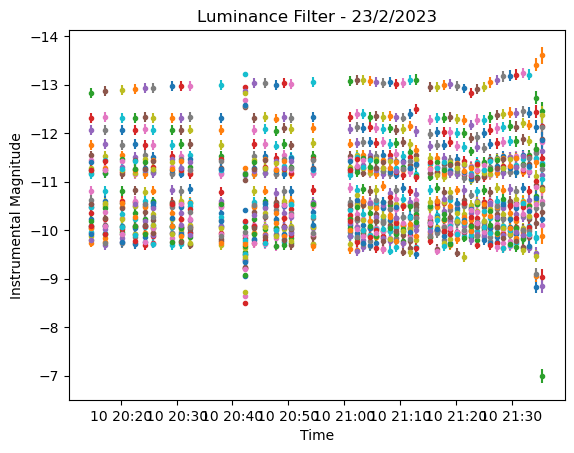

In [12]:
#plot all stars
for obs_data in range(len(star_properties)):
    for star_name in star_properties[obs_data]:
        img_num = []
        inst_mag = []
        mag_err = []
        date_time = []
        exp_time = []
        corrected_mag = []
        
        img_num.append(star_properties[obs_data][star_name]['img_number'])
        inst_mag.append(star_properties[obs_data][star_name]['instrumental_mag'])
        mag_err.append(abs(star_properties[obs_data][star_name]['mag_error']))
        date_time.append(star_properties[obs_data][star_name]['date_time'])
        exp_time.append(star_properties[obs_data][star_name]['exp_time'])
        
        if len(corrected_mag) == 0:
            corrected_mag.append(star_properties[obs_data][star_name]['corr_mag'])
        else:
            corrected_mag.append(star_properties[obs_data][star_name]['corr_mag'][0])
        
        date_time = pd.to_datetime(date_time)
        plt.errorbar(date_time, corrected_mag, yerr=mag_err, marker='.', ls='None', label=star_name)
    
plt.title('Luminance Filter - 23/2/2023')
plt.xlabel('Time')
plt.ylabel('Instrumental Magnitude')
plt.gca().invert_yaxis()
#plt.legend()
plt.show()

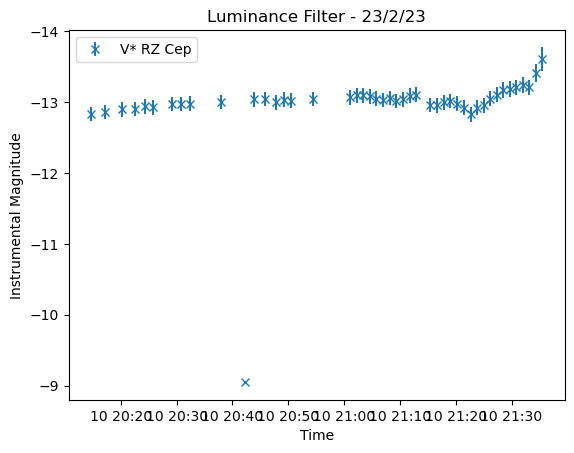

In [13]:
#plot example stars
img_num_star = []
inst_mag_star = []
mag_err_star = []
date_time_star = []
exp_time_star = []
corrected_mag = []

star_name = 'V* RZ Cep'

for obs_data in star_properties:
    if star_name in obs_data:
        img_num_star.append(obs_data[star_name]['img_number'])
        inst_mag_star.append(obs_data[star_name]['instrumental_mag'])
        mag_err_star.append(abs(obs_data[star_name]['mag_error']))
        date_time_star.append(obs_data[star_name]['date_time'])
        exp_time_star.append(obs_data[star_name]['exp_time'])
        

        corrected_mag.append(obs_data[star_name]['corr_mag'])

date_time_star = pd.to_datetime(date_time_star)

plt.errorbar(date_time_star, corrected_mag, yerr=mag_err_star, marker='x', ls='None', label=star_name)
plt.title('Luminance Filter - 23/2/23')
plt.xlabel('Time')
plt.ylabel('Instrumental Magnitude')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [14]:
#use ap stats error or sqrt counts

df_curve = pd.DataFrame(data=(corrected_mag, mag_err_star, date_time_star))
df_curve = df_curve.T
df_curve.columns = ['corrected_magnitude', 'magnitude_error', 'date_time']
df_curve.to_csv(final_csv_path / final_csv_name)

In [15]:
df_curve

,corrected_magnitude,magnitude_error,date_time
0,-9.047911,0.008997,2023-11-10 20:42:17.485
1,-13.039421,0.102456,2023-11-10 20:43:47.235
2,-13.042673,0.102609,2023-11-10 20:45:47.284
3,-12.996235,0.10219,2023-11-10 20:47:44.454
4,-13.033746,0.102233,2023-11-10 20:49:10.517
5,-13.020111,0.102648,2023-11-10 20:50:29.100
6,-13.045266,0.10326,2023-11-10 20:54:28.449
7,-12.831442,0.101823,2023-11-10 20:14:41.115
8,-12.863501,0.101995,2023-11-10 20:17:06.300
9,-12.896916,0.10212,2023-11-10 20:20:16.947
